# Tutorial about drift analysis and correction

Lateral drift correction is useful in most SMLM experiments. To determine the amount of drift a method based on image cross-correlation or an iterative closest point algorithm can be applied.

We demonstrate drift analysis and correction on simulated data.

In [1]:
from pathlib import Path

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import locan as lc

In [2]:
lc.show_versions(system=False, dependencies=False, verbose=False)


Locan:
   version: 0.7.dev3+gb9aca40

Python:
   version: 3.8.8


## Simulate data

We use synthetic data that follows a Neyman-Scott spatial distribution (blobs). The intensity values are exponentially distributed and the number of localizations per frame follows a Poisson distributions: 

In [3]:
n_samples = 100_000
intensity_mean = 1000
localizations_per_frame_mean = 3

In [4]:
lc.simulate_frame_numbers(n_samples, localizations_per_frame_mean)

array([    0,     0,     0, ..., 33396, 33397, 33398])

In [5]:
dat_blob = lc.simulate_Thomas(n_samples=n_samples, n_features=2, centers=100, feature_range=(0, 1000), cluster_std=10, seed=1)
dat_blob.dataframe['intensity'] = stats.expon.rvs(scale=intensity_mean, size=n_samples, loc=500)
dat_blob.dataframe['frame'] = lc.simulate_frame_numbers(n_samples, localizations_per_frame_mean)

dat_blob = lc.LocData.from_dataframe(dataframe=dat_blob.data)

print('Data head:')
print(dat_blob.data.head(), '\n')
print('Summary:')
dat_blob.print_summary()
print('Properties:')
print(dat_blob.properties)

Data head:
   position_x  position_y  cluster_label    intensity  frame
0   25.263587   17.251361             60  1352.794725      0
1  835.365471  535.640192             62   823.806766      0
2  689.692544  269.300349             88   541.796680      1
3  769.853155  351.796641             41   748.768890      1
4  314.389944  983.777211             85   828.655203      2 

Summary:
identifier: "2"
comment: ""
creation_date: "2021-03-04 13:44:27 +0100"
modification_date: ""
source: DESIGN
state: RAW
element_count: 100000
frame_count: 31745
file_type: UNKNOWN_FILE_TYPE
file_path: ""

Properties:
{'localization_count': 100000, 'position_x': 449.08893102170435, 'position_y': 521.7167259107333, 'region_measure_bb': 1106791.8085134837, 'localization_density_bb': 0.09035122886779273, 'subregion_measure_bb': 4208.21028352046}


C:\Miniconda3\envs\smlm_analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:title={'center':'counts'}, xlabel='position_x', ylabel='position_y'>

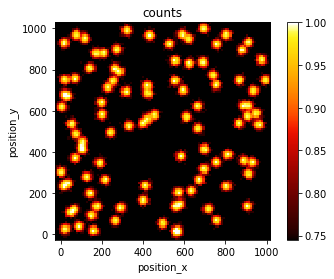

In [6]:
lc.render_2d(dat_blob, bin_size=10, rescale='equal');

## Add linear drift

We add linear drift with a velocity given in length units per frame.

In [7]:
dat_blob_with_drift = lc.add_drift(dat_blob, velocity=(0.002, 0.001), seed=1)

<AxesSubplot:title={'center':'frame'}, xlabel='position_x', ylabel='position_y'>

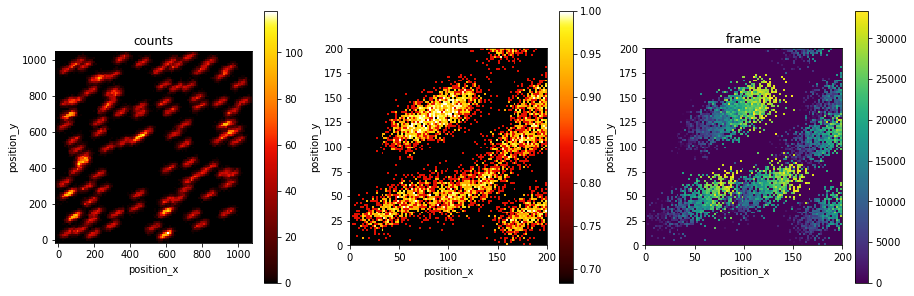

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
lc.render_2d(dat_blob_with_drift, ax=axes[0], bin_size=10);
lc.render_2d(dat_blob_with_drift, ax=axes[1], bin_size=2, rescale='equal', bin_range=((0, 200),(0, 200)));
lc.render_2d_mpl(dat_blob_with_drift, ax=axes[2], other_property='frame', bin_size=2, bin_range=((0, 200),(0, 200)), cmap='viridis');

## Estimate RMS errors

Knowing the ground truth, you can define a root mean squared error between the original localization coordinates and those after drift and and later after correction.

In [9]:
def rmse(locdata, other_locdata):
    return np.sqrt(np.mean(np.square(np.subtract(locdata.coordinates, other_locdata.coordinates)), axis=0))

In [10]:
rmse(dat_blob, dat_blob_with_drift).round(2)

array([38.64, 19.32])

## Estimate drift

Drift can be estimated by comparing different chunks of successive localizations using either an "iterative closest point" algorithm or a "cross-correlation" algorithm. Per default, the icp algorith is applied.

In [11]:
%%time
drift = lc.Drift(chunk_size=10_000, target='first', method='icp').compute(dat_blob_with_drift)

Wall time: 5.42 s


Transformations to register the different data chunks are represented by a transformation matrix and a transformation offset that together specifiy an affine transformation. The tansformation parameter are kept under the `transformations` attribute.

In [12]:
drift.transformations

[Transformation(matrix=array([[1., 0.],
        [0., 1.]]), offset=array([0., 0.])),
 Transformation(matrix=array([[ 9.98785651e-01, -3.60736184e-04],
        [ 3.60736184e-04,  9.98785651e-01]]), offset=array([-5.67353267, -2.53152939])),
 Transformation(matrix=array([[ 0.99876281, -0.0013322 ],
        [ 0.0013322 ,  0.99876281]]), offset=array([-11.84014308,  -6.85183166])),
 Transformation(matrix=array([[ 9.98465333e-01,  1.74409564e-04],
        [-1.74409564e-04,  9.98465333e-01]]), offset=array([-19.35439176,  -8.25566803])),
 Transformation(matrix=array([[ 9.99719713e-01, -5.44661793e-05],
        [ 5.44661793e-05,  9.99719713e-01]]), offset=array([-26.23247517, -13.11606125])),
 Transformation(matrix=array([[ 9.9897269e-01,  3.1415184e-05],
        [-3.1415184e-05,  9.9897269e-01]]), offset=array([-32.89000383, -16.02598885])),
 Transformation(matrix=array([[ 1.00004822e+00,  5.65189286e-04],
        [-5.65189286e-04,  1.00004822e+00]]), offset=array([-40.71155225, -19.59834515

The parameters can be visualized using the plot function. The matrix in this case is close to the unit matrix.

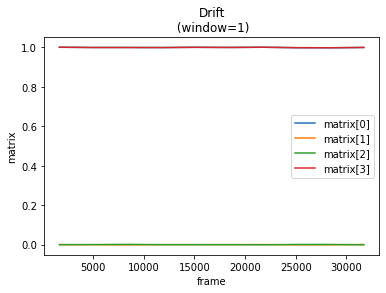

In [13]:
drift.plot(transformation_component='matrix', element=None);
plt.legend();

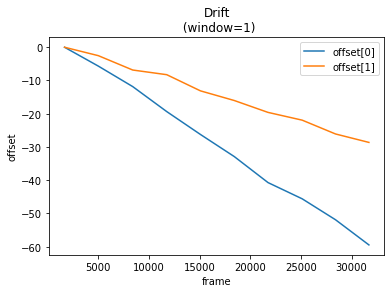

In [14]:
drift.plot(transformation_component='offset', element=None)
plt.legend();

## Model drift

A continuous transformation model as function of frame number is estimated by fitting the individual transformation components with the specified fit models. Fit models can be provided as `DriftComponent` or by a string representing standard model functions.

Drift(chunk_size=10000, target=first)

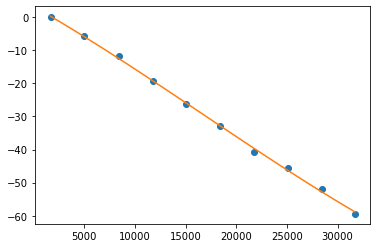

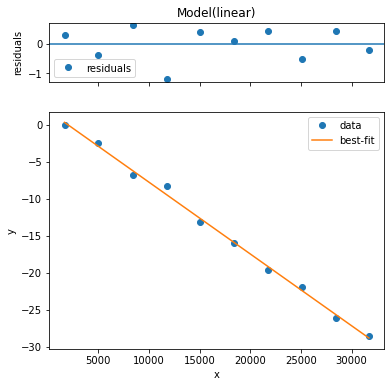

In [15]:
from lmfit.models import ConstantModel, LinearModel, PolynomialModel

drift.fit_transformations(slice_data=slice(None), offset_models=(lc.DriftComponent('spline', s=100), 'linear'), verbose=True);

The fit models are represented as `DriftComponent` and can be accessed through the transformation_models attribute.

In [16]:
drift.transformation_models

{'matrix': None,
 'offset': [<locan.analysis.drift.DriftComponent at 0x2a347c10f40>,
  <locan.analysis.drift.DriftComponent at 0x2a347c42a30>]}

Each `DriftModel` carries detailed information about the fit under the model_result attribute. In most cases, except splines, this will be a `lmfit.ModelResult` object. 

In [17]:
drift.transformation_models['offset'][0].type

'spline'

In [18]:
drift.transformation_models['offset'][0].eval(0)

3.3004971889739103

In [19]:
drift.transformation_models['offset'][0].model_result

(array([ 1681.3847,  1681.3847,  1681.3847,  1681.3847, 31711.1537,
        31711.1537, 31711.1537, 31711.1537]),
 array([  0.31422654, -17.75531375, -40.83624303, -58.83846101,
          0.        ,   0.        ,   0.        ,   0.        ]),
 3)

In [20]:
drift.transformation_models['offset'][1].type

'linear'

In [21]:
drift.transformation_models['offset'][1].model_result

## Drift correction

The estimated drift is corrected by applying a transformation on the localization chunks (from_model=False).

In [22]:
%%time
drift.apply_correction(from_model=False);

Wall time: 164 ms


Drift(chunk_size=10000, target=first)

<AxesSubplot:title={'center':'frame'}, xlabel='position_x', ylabel='position_y'>

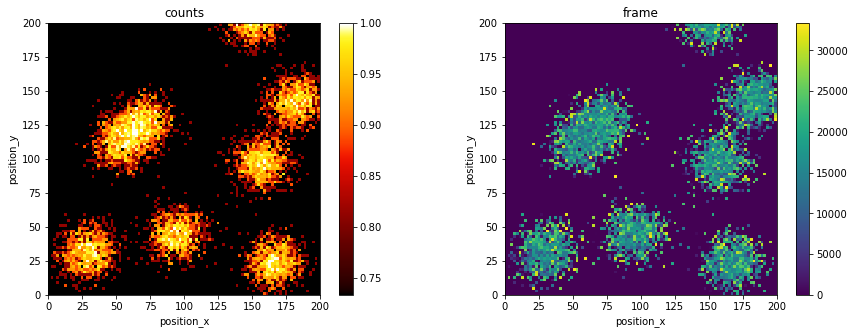

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
lc.render_2d(drift.locdata_corrected, ax=axes[0], bin_size=2, rescale='equal', bin_range=((0, 200),(0, 200)));
lc.render_2d_mpl(drift.locdata_corrected, ax=axes[1], other_property='frame', bin_size=2, bin_range=((0, 200),(0, 200)), cmap='viridis');

In [24]:
rmse(dat_blob, drift.locdata_corrected).round(2)

array([9.83, 5.13])

Or the estimated drift is corrected by applying a transformation on each individual localization using the drift models (from_model=True).

In [25]:
%%time
drift.apply_correction(from_model=True)

Wall time: 28.6 ms


Drift(chunk_size=10000, target=first)

<AxesSubplot:title={'center':'frame'}, xlabel='position_x', ylabel='position_y'>

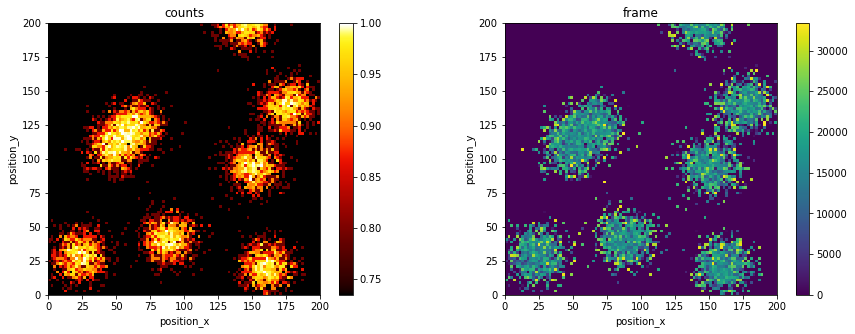

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
lc.render_2d(drift.locdata_corrected, ax=axes[0], bin_size=2, rescale='equal', bin_range=((0, 200),(0, 200)));
lc.render_2d_mpl(drift.locdata_corrected, ax=axes[1], other_property='frame', bin_size=2, bin_range=((0, 200),(0, 200)), cmap='viridis');

In [27]:
rmse(dat_blob, drift.locdata_corrected).round(2)

array([4.12, 2.45])

In [28]:
drift.locdata_corrected.meta

identifier: "26"
creation_date: "2021-03-04 13:44:27 +0100"
modification_date: "2021-03-04 13:44:35 +0100"
source: DESIGN
state: MODIFIED
history {
  name: "LocData.from_dataframe"
}
history {
  name: "add_drift"
  parameter: "{\'locdata\': <locan.data.locdata.LocData object at 0x000002A347748E20>, \'diffusion_constant\': None, \'velocity\': (0.002, 0.001), \'seed\': 1}"
}
history {
  name: "apply_correction"
  parameter: "{\'self\': Drift(chunk_size=10000, target=first), \'locdata\': None, \'from_model\': True}"
}
ancestor_identifiers: "2"
ancestor_identifiers: "3"
element_count: 100000
frame_count: 31745

## Drift analysis by a cross-correlation algorithm

The same kind of drift estimation and correction can be applied using the image cross-correlation algorithm.

C:\Miniconda3\envs\smlm_analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Wall time: 492 ms


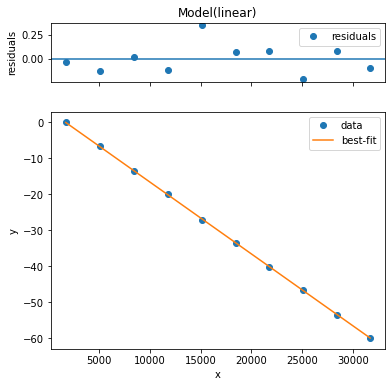

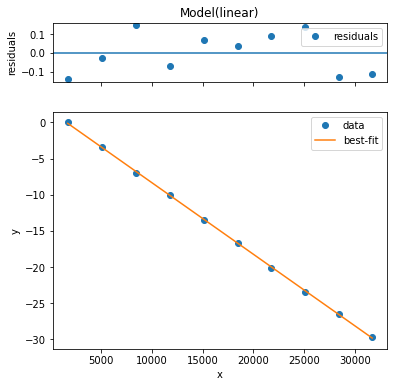

In [29]:
%%time
drift = lc.Drift(chunk_size=10_000, target='first', method='cc').\
        compute(dat_blob_with_drift).\
        fit_transformations(slice_data=slice(None), offset_models=(LinearModel(), LinearModel()), verbose=True).\
        apply_correction(from_model=True);

<AxesSubplot:title={'center':'frame'}, xlabel='position_x', ylabel='position_y'>

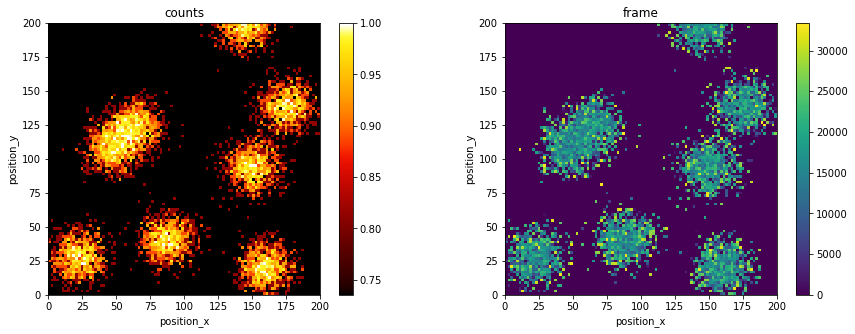

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
lc.render_2d(drift.locdata_corrected, ax=axes[0], bin_size=2, rescale='equal', bin_range=((0, 200),(0, 200)));
lc.render_2d_mpl(drift.locdata_corrected, ax=axes[1], other_property='frame', bin_size=2, bin_range=((0, 200),(0, 200)), cmap='viridis');

In [31]:
rmse(dat_blob, drift.locdata_corrected)

array([3.38012308, 1.71866456])